In [62]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=6, suppress=True)
cuda = torch.device('cuda')

In [76]:
data=np.load("/its/home/drs25/Quadruped/Code/data_collect_proj/dataset.npy")
X=data[:,:,:12] #motors
y=data[:,:,12:] #tilt of robot
print(X.shape,y.shape)
ar=[]
TEMPORAL_WINDOW=40
for j in range(len(y)):
    for i in range(0,1000,TEMPORAL_WINDOW):
        ar.append(y[j][i])
y=np.array(ar)
#break down further
X=np.concatenate([X[:,i:i+TEMPORAL_WINDOW] for i in range(0,1000,TEMPORAL_WINDOW)])

print(X.shape,y.shape)

(200, 1000, 12) (200, 1000, 3)
(5000, 40, 12) (5000, 3)


## modelling LSTM

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Take the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        return out

In [78]:
input_size = 12  # For a univariate time series input
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 3  # For regression (change for classification)
num_epochs = 100
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, num_layers, output_size).cuda()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X=torch.tensor(X,dtype=torch.float32).cuda()
y=torch.tensor(y,dtype=torch.float32).cuda()
dataset = TensorDataset(X, y)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%20==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0464
Epoch [21/100], Loss: 0.0235


### visualise predictions

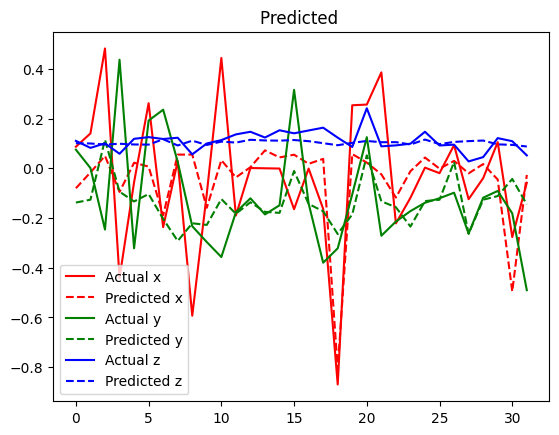

In [75]:
for inputs, targets in train_loader:
    preds=model(inputs).cpu().detach().numpy()
    break

c=["r","g","b"]
axis=["x","y","z"]
for i in range(3):
    plt.title("Input")
    plt.plot(targets[:,i].cpu().detach().numpy(),c=c[i],label="Actual "+axis[i])
    plt.plot(preds[:,i],"--",c=c[i],label="Predicted "+axis[i])

plt.legend(loc="lower left")
plt.title("Predicted tilt")
plt.show()